In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import scipy.integrate
import scipy.stats
import scipy.special
from scipy.special import erf
import scipy.misc

In [3]:
%matplotlib inline

# Run this cell twice for some reason or otherwise it doesn't work
# https://discourse.matplotlib.org/t/bug-rcparams-doesnt-work-first-time-v3-5-2/22853
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [4]:
file = uproot.open('../../geant/data/bigdatasample/output_full_50m.root')
fulldata = file['Edep'].arrays(library='pd')
fulldatarecoils = file['Recoils'].arrays(library='pd')

In [5]:
file = uproot.open('../../geant/data/bigdatasample/output_full_50m_fieldCage.root')
fieldcagedata = file['Edep'].arrays(library='pd')
fieldcagerecoils = file['Recoils'].arrays(library='pd')

In [6]:
file = uproot.open("../../geant/data/bigdatasample/output_full_50m_fieldCage_re_coincidences_3D.root")
coincidencedata = file['Pairwise Distances'].arrays(library='pd')
#meta = file['Metadata'].arrays(library='pd')

In [33]:
file = uproot.open('../../geant/data/bigdatasample/output_full_50m_flux.root')
fluxdata = file['Entering Flux']['neutron']['posz'].arrays(library='pd')

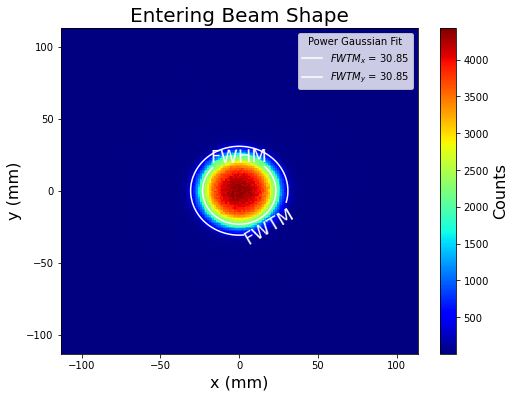

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))

(z, x, y, img) = ax.hist2d(fluxdata['Coord1 (mm)'], fluxdata['Coord2 (mm)'], bins=200, cmap=plt.cm.jet)

# Average the left and right values for each hist bin
x = np.convolve(x, np.ones(2)/2, mode='valid')
y = np.convolve(y, np.ones(2)/2, mode='valid')
""
# Fit the histogram using a Power Gaussian

# Don't use this function except in this cell really, it is terrible
def GaussFit2DArr(r, amplitude, sigma_x, sigma_y, mu_x, mu_y, offset, power):
    x = r - np.array([[mu_x], [mu_y]])
    
    # inverse of covariance matrix
    sigma = [[1 / (sigma_x ** 2), 0], [0, 1 / (sigma_y ** 2)]]
    
    return offset + amplitude * np.exp(- (0.5 * np.transpose(x, (0, 2, 1)) @ (sigma @ x)).ravel() ** power)

r = np.array(np.meshgrid(x, y)).T.reshape((-1, 2, 1))

fluxbounds = ([0, 0, 0, -np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
fluxpopt, fluxpcov = scipy.optimize.curve_fit(GaussFit2DArr, r, z.ravel(), p0=(500, 20, 20, 0, 0, z[0, 0], 1), bounds=fluxbounds)

fluxfit = GaussFit2DArr(r, *fluxpopt).reshape(x.shape[0], -1)

CS = ax.contour(x, y, fluxfit, levels=[fluxpopt[0] / 10 + fluxpopt[5], fluxpopt[0] / 2 + fluxpopt[5]],colors='w')
ax.clabel(CS, CS.levels, inline=True, fmt={CS.levels[0] : "FWTM", CS.levels[1] : "FWHM"}, fontsize=18)

cbar = fig.colorbar(img, ax=ax)
cbar.ax.set_ylabel('Counts', fontsize=16)

ax.set_xlabel('x (mm)', fontsize=16)
ax.set_ylabel('y (mm)', fontsize=16)
ax.set_title('Entering Beam Shape', fontsize=20)

fwhmWidthX = (np.max(CS.allsegs[1][0][:,0]) - np.min(CS.allsegs[1][0][:,0])) / 2
fwtmWidthX = (np.max(CS.allsegs[0][0][:,0]) - np.min(CS.allsegs[0][0][:,0])) / 2
fwhmWidthY = (np.max(CS.allsegs[1][0][:,1]) - np.min(CS.allsegs[1][0][:,1])) / 2
fwtmWidthY = (np.max(CS.allsegs[0][0][:,1]) - np.min(CS.allsegs[0][0][:,1])) / 2

# Dummy plot to add a legend label
ax.plot(0, 0, "-", c='w', label='$FWTM_x$ = %.2f' % (fwtmWidthX))
ax.plot(0, 0, "-", c='w', label='$FWTM_y$ = %.2f' % (fwtmWidthY))

ax.legend(title="Power Gaussian Fit")

plt.show()

In [63]:
# Real counts of neutrons entering detector region
activeIncidentNeutrons = fluxdata.shape[0] - background * np.array(np.meshgrid(x, y)).shape[1] * np.array(np.meshgrid(x, y)).shape[2]

In [64]:
fulldatarecoils = fulldatarecoils[fulldatarecoils['Particle Name'] != 'e-']
fieldcagerecoils = fieldcagerecoils[fieldcagerecoils['Particle Name'] != 'e-']
fieldcagerecoils

,Event ID,Track ID,Parent ID,Global Time (ns),Particle Name,Energy (keV),Position x (mm),Position y (mm),Position z (mm),Process
0,32530,3,1,91.078851,F19,169.341072,-6.409404,1.987524,25.561234,neutronInelastic
1,53219,3,1,90.979190,F19,195.510912,-5.111441,-11.680597,7.390478,neutronInelastic
2,65789,2,1,93.568663,F19,445.780513,-18.988146,-0.432484,-26.425911,hadElastic
3,124198,3,1,90.932510,F19,455.421171,-15.053559,-5.762844,-0.564505,neutronInelastic
4,150978,2,1,94.330723,C12,524.704793,16.599612,-14.671426,-41.769123,hadElastic
...,...,...,...,...,...,...,...,...,...,...
1380,49859175,3,1,92.623879,F19,34.995559,6.152396,-4.447297,-7.136357,neutronInelastic
1381,49871261,2,1,91.796776,C12,579.525576,-21.315057,-5.220563,5.636153,hadElastic
1382,49917162,3,1,92.835355,F19,65.127020,-1.780954,-9.254797,-7.147002,neutronInelastic
1383,49943599,2,1,92.717168,C12,671.430912,19.028616,2.769501,-28.518423,hadElastic


In [75]:
# Probability of nuclear recoil in field cage per incident neutron
pNR = fieldcagerecoils.shape[0] / activeIncidentNeutrons

dpNR = pNR / np.sqrt(fieldcagerecoils.shape[0])

In [76]:
# Filter and only take edeps from electrons
fulldata = fulldata[fulldata['Particle Name'] == 'e-']
fieldcagedata = fieldcagedata[fieldcagedata['Particle Name'] == 'e-']
coincidencedataonlye = coincidencedata[coincidencedata['Particle 2'] == 'e-']

In [77]:
# This portion of edeps happens inside the field cage
fieldcagedata.shape[0]/fulldata.shape[0]

0.016319129646418858

In [98]:
pEEdep = fieldcagedata.shape[0] / activeIncidentNeutrons

dpEEdep = pEEdep / np.sqrt(fieldcagedata.shape[0])

In [80]:
# NOT A COUNTS HISTOGRAM, INSTEAD A PDF FOR GETTING A COUNT AT A CERTAIN ENERGY
(edepbars, edepbins) = np.histogram(fulldata['Edep (keV)'], bins=100, density=True)
edepwidth = edepbins[1] - edepbins[0]

edepbarsigma = np.where(np.sqrt(edepbars) == 0, 1, np.sqrt(edepbars))

#edepbars = edepbars / iterations * generatorPulsesPerSecond
#edepbarsigma = edepbarsigma / iterations * generatorPulsesPerSecond

edepbins = np.convolve(edepbins, np.ones(2) / 2, mode='valid')

def expDistFit(x, expParameter):
    return expParameter * np.exp(- expParameter * (x - 2))

edeppopt, edeppcov = scipy.optimize.curve_fit(expDistFit, edepbins, edepbars, absolute_sigma=True, sigma=edepbarsigma, bounds=([0], [np.inf]))

edepfitx = np.linspace(np.min(edepbins), np.max(edepbins), 1000)
edepfity = expDistFit(edepfitx, *edeppopt)

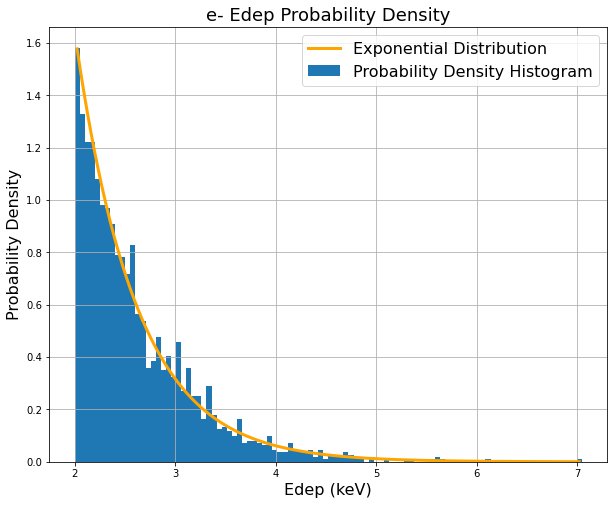

In [15]:
fig, ax = plt.subplots()

ax.bar(edepbins, edepbars, edepwidth, label='Probability Density Histogram')
ax.plot(edepfitx, edepfity, color='orange', zorder=10, label='Exponential Distribution', linewidth=3)

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Edep (keV)', fontsize=16)
ax.set_ylabel('Probability Density', fontsize=16)
ax.set_title('e- Edep Probability Density', fontsize=18)

plt.show()

In [30]:
# total portion counts expected in the specified integration range
scipy.integrate.quad(lambda x : expDistFit(x, *edeppopt), 5, 15)

(0.007198377854880245, 1.9674806043073127e-11)

In [144]:
# Counts expected per however many neutrons were shot in the simulation
print(scipy.integrate.quad(lambda x : expDistFit(x, *edeppopt), 2, 15)[0] * fulldata.shape[0])
pElectronRecoilInEnergyRange = scipy.integrate.quad(lambda x : expDistFit(x, *edeppopt), 2, 15)[0]

dpElectronRecoilInEnergyRange = pElectronRecoilInEnergyRange / np.sqrt(fulldata.shape[0])

2205.999998856361


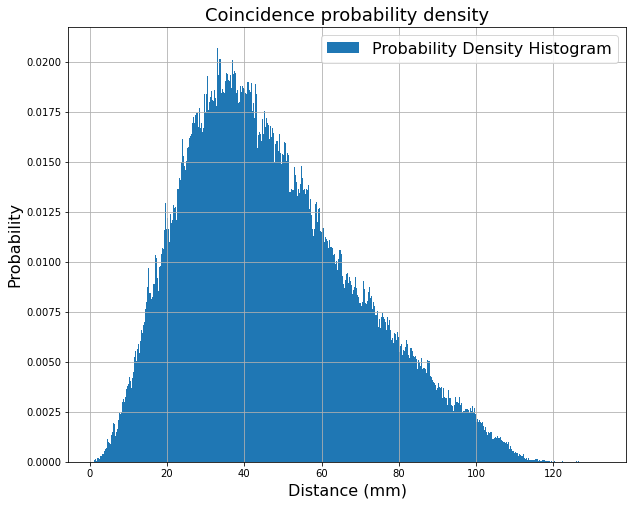

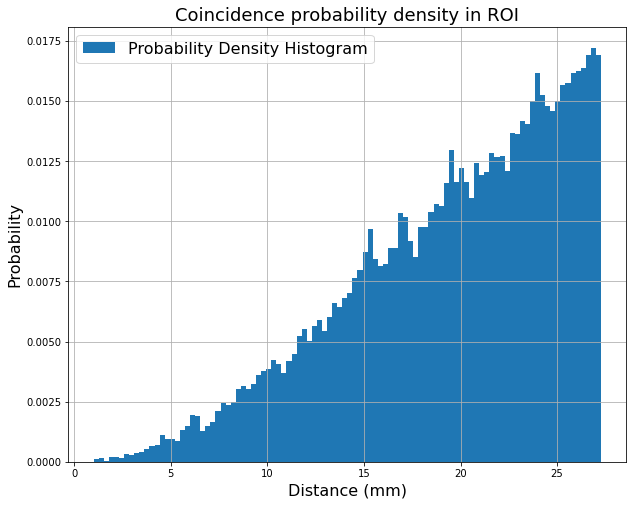

In [21]:
(coincidencebars, coincidencebins) = np.histogram(coincidencedata['Distance (mm)'], bins=500, density=True)
coincidencewidth = coincidencebins[1] - coincidencebins[0]
coincidencebins = np.convolve(coincidencebins, np.ones(2) / 2, mode='valid')

fig, ax = plt.subplots()

ax.bar(coincidencebins, coincidencebars, coincidencewidth, label='Probability Density Histogram')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance (mm)', fontsize=16)
ax.set_ylabel('Probability', fontsize=16)
ax.set_title('Coincidence probability density', fontsize=18)

plt.show()

roi =slice(0, 100)

fig, ax = plt.subplots()

ax.bar(coincidencebins[roi], coincidencebars[roi], coincidencewidth, label='Probability Density Histogram')

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance (mm)', fontsize=16)
ax.set_ylabel('Probability', fontsize=16)
ax.set_title('Coincidence probability density in ROI', fontsize=18)

plt.show()

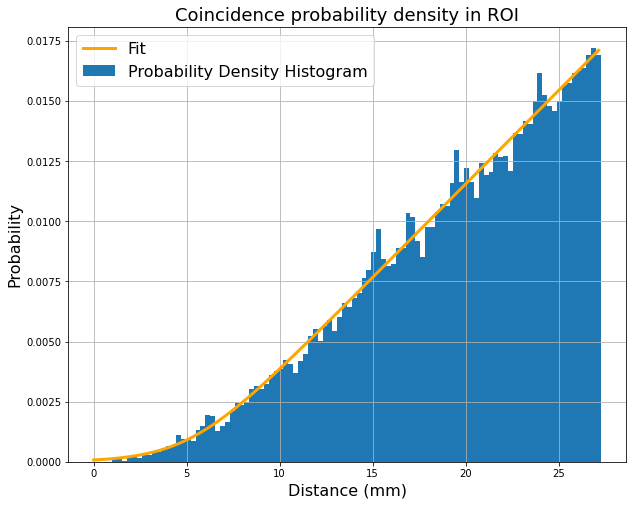

In [22]:
def coincidenceFit(x, a, b, c):
    return c * np.log(1 + a * np.exp(b * x))

coincidencepopt, coincidencepcov = scipy.optimize.curve_fit(coincidenceFit, coincidencebins[roi], coincidencebars[roi], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

coincidencefitx = np.linspace(0, np.max(coincidencebins[roi]), 100)
coincidencefity = coincidenceFit(coincidencefitx, *coincidencepopt)

fig, ax = plt.subplots()

ax.bar(coincidencebins[roi], coincidencebars[roi], coincidencewidth, label='Probability Density Histogram')
ax.plot(coincidencefitx, coincidencefity, color='orange', zorder=10, label='Fit', linewidth=3)

ax.grid()
ax.legend(fontsize=16)

ax.set_xlabel('Distance (mm)', fontsize=16)
ax.set_ylabel('Probability', fontsize=16)
ax.set_title('Coincidence probability density in ROI', fontsize=18)

plt.show()

In [133]:
coincidencepcov

array([[ 4.35970431e-04, -1.75607161e-03,  4.55096163e-06],
       [-1.75607161e-03,  7.54489271e-03, -1.99021082e-05],
       [ 4.55096163e-06, -1.99021082e-05,  5.27962980e-08]])

In [113]:
# total portion of coincidences  expected in the specified integration range
print(scipy.integrate.quad(lambda x : coincidenceFit(x, *coincidencepopt), 0, 1))
pPairIsCoincidence = scipy.integrate.quad(lambda x : coincidenceFit(x, *coincidencepopt), 0, 1)[0]

dpPairIsCoincidence = 0

(0.00010093002730596216, 1.1205484019112495e-18)


In [148]:
#nParticlesPerWindow = 3 * 1e5 / 100
nParticlesPerWindow = 1e6 / (4 * np.pi) * 0.1 / 250
dnParticlesPerWindow = np.sqrt(nParticlesPerWindow)

expectedPairsFor1mNR = (10e6) * nParticlesPerWindow * pEEdep * 16 / 2206 * pElectronRecoilInEnergyRange
dExpectedPairsFor1mNR = expectedPairsFor1mNR * np.sqrt( (dnParticlesPerWindow / nParticlesPerWindow) ** 2 + (dpEEdep / pEEdep) ** 2 + (dpElectronRecoilInEnergyRange / pElectronRecoilInEnergyRange) ** 2)
print("Expecting ", expectedPairsFor1mNR, "+/-", dExpectedPairsFor1mNR, " pairs in field cage during 1m NR")

expectedCoincidences = pPairIsCoincidence * expectedPairsFor1mNR
dExpectedCoincincidences = expectedCoincidences * np.sqrt( (dpPairIsCoincidence / pPairIsCoincidence) ** 2 + (dExpectedPairsFor1mNR / expectedPairsFor1mNR) ** 2)
print("Expecting ", expectedCoincidences, "+/-", dExpectedCoincincidences, " coincidences per 1m NR given specified cuts")

Expecting  14.354637789366487 +/- 3.5057955878103497  pairs in field cage during 1m NR
Expecting  0.001448813984047956 +/- 0.0003538400444068203  coincidences per 1m NR given specified cuts
